### Modelling the PMS data 


Household vulnerability assessment will be categorised as follows using a percentile of ranked household PMT scores;

1. Very poor  <= 25th percentile>
2. Poor >25th percentile and <=50th percentile>
3. Middle >50 and <= 75th percentile>
4. Better off >= 75th percentile

In [1]:
import psycopg2
import pandas as pd
import datetime

In [2]:
host = 'Enter host name here'
username = 'Enter username here'
password = 'Enter password here'

In [3]:
def get_db_connection(host,username,password):
    conn = psycopg2.connect(
        host= host,
        database= "PMT_UHC",
        user= username,
        password= password)
    return conn

In [4]:
conn = get_db_connection(host,username,password)
cur = conn.cursor()

In [5]:
# SELECT "index", country_id, country_name, county_id, county_name, subcounty_id, subcounty_name, lat_subcounty, lon_subcounty, ward_id, ward_name, lat_ward, lon_ward, chu_id, chu_name, link_fac, village_id_x, village_name, hh_num, hh_id, village_id_y, lat, long, member_number, marital_status, max_education, village_number, urban_constant_figure, rural_constant_figure, nairobi_constant_figure, past_week_activity, weight_status, employment
# FROM public."Pmt_uhc";

In [6]:
%%time
cur.execute('SELECT country_id, country_name, county_id, county_name, subcounty_id, subcounty_name, lat_subcounty, lon_subcounty, ward_id, ward_name, lat_ward, lon_ward, chu_id, chu_name, link_fac, village_id_x, village_name, hh_num, hh_id, village_id_y, lat, long, member_number, marital_status, max_education, village_number, urban_constant_figure, rural_constant_figure, nairobi_constant_figure, past_week_activity, weight_status, employment from pmt_uhc')
df = cur.fetchall()
df = pd.DataFrame(df)


CPU times: total: 31.8 s
Wall time: 4min 55s


In [7]:
df.columns = ["country_id", "country_name", "county_id", "county_name", "subcounty_id", "subcounty_name", "lat_subcounty", "lon_subcounty", "ward_id", "ward_name", "lat_ward", "lon_ward", "chu_id", "chu_name", "link_fac", "village_id_x", "village_name", "hh_num", "hh_id", "village_id_y", "lat", "long", "member_number", "marital_status", "max_education", "village_number", "urban_constant_figure", "rural_constant_figure", "nairobi_constant_figure", "past_week_activity", "weight_status", "employment"]
df.head()

,country_id,country_name,county_id,county_name,subcounty_id,subcounty_name,lat_subcounty,lon_subcounty,ward_id,ward_name,...,member_number,marital_status,max_education,village_number,urban_constant_figure,rural_constant_figure,nairobi_constant_figure,past_week_activity,weight_status,employment
0,1,Kenya,3,Kilifi,11,Kilifi North,-3.510651,39.909327,51,Tezo,...,307439648614847474C59EAFE4KAWIQ5,Widowed,Pre-Primary,7262.0,8.71438,0.0,0.0,No work available,Urban,Not Employed
1,1,Kenya,3,Kilifi,11,Kilifi North,-3.510651,39.909327,51,Tezo,...,307439648617726638L85LFASP9WP9U5,Married mono-gamous,Pre-Primary,7262.0,8.89718,0.0,0.0,No work available,Urban,Not Employed
2,1,Kenya,3,Kilifi,11,Kilifi North,-3.510651,39.909327,51,Tezo,...,307439648617148812S57KM9CEMV8VO2,Married mono-gamous,Pre-Primary,7262.0,8.72218,0.0,0.0,No work available,Urban,Not Employed
3,1,Kenya,3,Kilifi,11,Kilifi North,-3.510651,39.909327,51,Tezo,...,307439648616579485TNYFIYARM5SCFZ,Widowed,Pre-Primary,7262.0,8.71438,0.0,0.0,No work available,Urban,Not Employed
4,1,Kenya,3,Kilifi,11,Kilifi North,-3.510651,39.909327,51,Tezo,...,3074396486112467629JEX82JXMOQCVN,Married mono-gamous,Secondary,7262.0,9.42108,0.0,0.0,Worked for pay,Urban,Employed


In [8]:
df1 = df[df['weight_status'].isin(["Rural","Urban"])]
df1['weight_status'].value_counts()


Rural    420141
Urban     98252
Name: weight_status, dtype: int64

array([[<AxesSubplot:title={'center':'urban_constant_figure'}>,
        <AxesSubplot:title={'center':'rural_constant_figure'}>]],
      dtype=object)

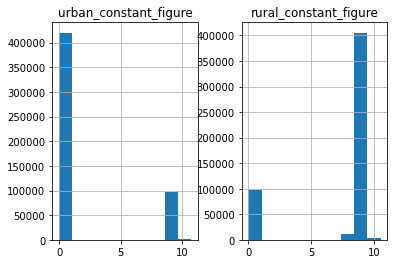

In [9]:
df1[['urban_constant_figure','rural_constant_figure']].hist()

In [10]:
df1[['urban_constant_figure','rural_constant_figure',"PMT"]].describe()

KeyError: "['PMT'] not in index"

In [ ]:
df1["Target"] = ['very_poor' if i <2.5 else 'poor' if i<5 else 'middle' if i<7.5 else 'better off' for i in df1['PMT']]

In [ ]:
# Test code
import numpy as np
x = np.array([10,7,6,2,5,1,9])
y = pd.Series(x)
y.quantile(0.5)

In [ ]:
y.median()

In [ ]:
y = df1['urban_constant_figure'][df1['urban_constant_figure']>0]
lower = y.quantile(0.25)
mid = y.quantile(0.5)
upper = y.quantile(0.75)
print(y.min(),lower,mid,upper,y.max())
df1["PMT_urban"] = ["##" if i <=0.0 else 'betteroff' if i <=lower else "middle"if i<=mid else "poor" if i<= upper else "very_poor" for i in df1['urban_constant_figure']]
df1["PMT_urban"].value_counts()

In [ ]:
y = df1['rural_constant_figure'][df1['rural_constant_figure']>0]
lower = y.quantile(0.25)
mid = y.quantile(0.5)
upper = y.quantile(0.75)
print(y.min(),lower,mid,upper,y.max())
df1["PMT_rural"] = ["##" if i <=0.0 else 'betteroff' if i <=lower else "middle"if i<=mid else "poor" if i<= upper else "very_poor" for i in df1['rural_constant_figure']]
df1["PMT_rural"].value_counts()

In [ ]:
final = []
for x,y,z in zip(df1['PMT_rural'],df1['PMT_urban'],df1['weight_status']):
    if z=="Rural":
        final.append(x)
    elif z =="Urban":
        final.append(y)
    else:
        final.append("##")
df1["Target"] = final   

Urban - Kwale, Kilifi, Tana River, Lamu, Taita Taveta. 0 – No. 1 – Yes.

Rural - Kitui, Machakos, Makueni, Kakamega, Vihiga, Bungoma, Busia, Siaya, Kisumu, Homa Bay, Migori, Kisii, Nyamira

In [ ]:
df1['Target'].value_counts()

In [ ]:
df1['weight_status'].value_counts()

In [ ]:
df1.columns

In [ ]:
# define the final columns
df2 = df1.drop([ 'PMT_urban',
       'PMT_rural', 'Finalpmt','village_id_y'],axis = 1)

In [ ]:
df2.columns

In [ ]:
df2 = df2.rename(columns = {'village_id_x':'village_id'})
df2.columns

In [ ]:
%%time

from sqlalchemy import create_engine
 
engine = create_engine(url=r"postgresql://{0}:{1}@{2}/{3}".format(username, password, host, 'PMT_UHC'))

# attach the data frame to the sql
# with a name of the table
# as "insurance_coverage" 
# *this code replaces the existing table everytime, but can be modified to append to the existing data

df2.to_sql('pmt_classification', con = engine, if_exists="replace")

Next steps
- using the village name to get geopoints
- using the mfl code to geopoints for facilities
- Calculate distance from village to facility
- dashboarding